# 8 Modeling a Drone Swinging in a Trifilar Pendulum

A trifilar pendulum is a common tool for determining the inertia of a rigid body. In the video below a small quadcopter drone is hung from a trifilar pendulum and set into an oscillation about the vertical axis. The frequency (or period) of this oscillation correlates with the inertia of the drone about the axis of rotation. In this notebook you will learn how to create a mathematical model of this system.

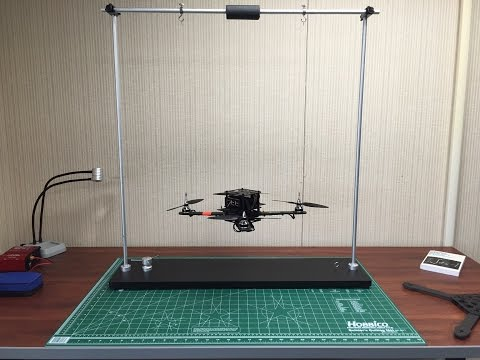

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('HrG7xhrLbWo')

In [2]:
import numpy as np
import sympy as sm
sm.init_printing()

In [3]:
%matplotlib inline

# System parameters

We introduced a number of variable to describe the geometry in the problem:

- $m$: total mass of the drone
- $l$: length of the very stiff strings
- $I$: rotational inertia of the drone about a vertical axis and with respect to the center of mass
- $g$: acceleration due to gravity
- $r$: the radial distance from the center of mass to the location of the string attachments

In [4]:
m, I, g, l, r = sm.symbols('m, I, g, l, r', real=True, positive=True)

The goal is to write the equations of motion in terms of the generalized coordinate. In our case are going to use the rotational angle of the drone, $\theta$. This variable should be a function of time.

In [5]:
t = sm.symbols('t')

In [6]:
theta = sm.Function('theta')(t)
theta

With $\theta$ being a function of time the first and second derivatives can be easily taken with `.diff()`.

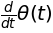

In [7]:
theta.diff(t)

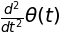

In [8]:
theta.diff(t, 2)

# Getting the geometry and velocity right

The height of the drone from its equilibrium resting position is written in terms of $\theta$ below.

In [9]:
h = l - sm.sqrt(l**2 - (2 * r * sm.sin(theta / 2))**2)
h

The time derivative of $h$ is also needed to compute the linear kinetic energy.

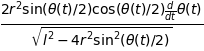

In [10]:
v = h.diff(t)
v

This can be simplified a bit:

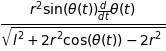

In [11]:
v = sm.trigsimp(v)
v

# Forming the Lagrangian

Now the total kinetic energy can be formed by summing the linear and rotational kinetic energies:

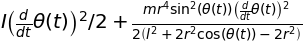

In [12]:
T = m * v**2 / 2 + I * theta.diff()**2 / 2
T

The total potential energy is:

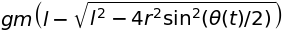

In [13]:
U = m * g * h
U

The Lagrangian:

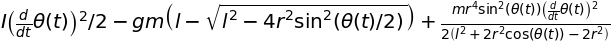

In [14]:
L = T - U
L

# Forming and evaluating Lagrange's Equation

Now Lagrange's equation of the second kind can be formed with respect to the single generalized coordinate.

$$\frac{d}{dt}\left(\frac{\partial L}{\partial \dot{\theta}}\right) - \frac{\partial L}{\partial \theta} = 0$$

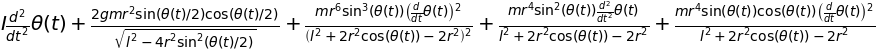

In [15]:
zero = L.diff(theta.diff(t)).diff(t) - L.diff(theta)
zero

Some trigonometric simplification can clean it up a bit:

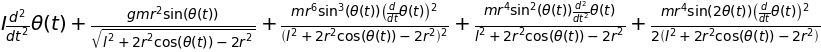

In [16]:
zero = sm.trigsimp(zero)
zero

# Putting the equations of motion into first order form

The equation of motion is linear with respect to $\ddot{\theta}$ and the coefficient can be extracted with:

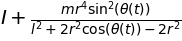

In [17]:
acc_coeff = zero.coeff(theta.diff(t, 2))
acc_coeff

This system can be put into first order form by introducing a new variable $\omega = \dot{\theta}$ (this relationship is also the first of the two ODEs). The second is then:

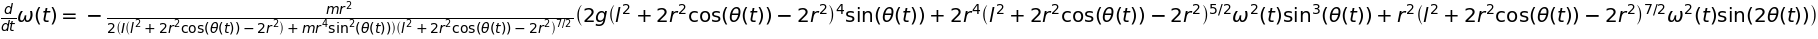

In [18]:
omega = sm.Function('omega')(t)
omega_dot = sm.simplify(-(zero.subs({theta.diff(): omega}) - acc_coeff * omega.diff()) / acc_coeff)
sm.Eq(omega.diff(), omega_dot)

# Simulating the nonlinear equations of motion

In [19]:
from resonance.nonlinear_systems import SingleDoFNonLinearSystem

In [20]:
nl_sys = SingleDoFNonLinearSystem()

In [21]:
nl_sys.constants['m'] = 1  # kg
nl_sys.constants['r'] = 0.3  # m
nl_sys.constants['l'] = 0.75  # m
nl_sys.constants['g'] = 9.81  # m/s**2
nl_sys.constants['I'] = 0.3**2  # kg m**2

nl_sys.coordinates['theta'] = np.deg2rad(15) # rad
nl_sys.speeds['omega'] = 0.0  # rad/s

The 2nd order differential equations for a non-linear system have to be specificied in explicit first order form for most numerical integration routines (which is what is used behind the scenes in resonance). This means we need to introduce a new variable, a generalized speed, that defines the first of the two first order equations. We also have to move everything to the right hand side of the equations except for terms with derivatives.:

$$
\dot{\theta} = \omega \\
\dot{\omega} = f(\omega, \theta, m, r, l, g, I, t)
$$

You have to create a function that computes the time derivatives of the coordinates and speeds (the states) given the current values of the coordinates and speeds. The function will have arguments that match your variable names defined above and it **must output the time derivatives that correspond to the order of `sys.states`.** See below how to translate this mathematical expression into a "right hand side" function.

Option 1) Copy code form SymPy output and modify by hand:

In [22]:
str(omega_dot)

'-m*r**2*(2*g*(l**2 + 2*r**2*cos(theta(t)) - 2*r**2)**4*sin(theta(t)) + 2*r**4*(l**2 + 2*r**2*cos(theta(t)) - 2*r**2)**(5/2)*omega(t)**2*sin(theta(t))**3 + r**2*(l**2 + 2*r**2*cos(theta(t)) - 2*r**2)**(7/2)*omega(t)**2*sin(2*theta(t)))/(2*(I*(l**2 + 2*r**2*cos(theta(t)) - 2*r**2) + m*r**4*sin(theta(t))**2)*(l**2 + 2*r**2*cos(theta(t)) - 2*r**2)**(7/2))'

In [23]:
def eval_rhs(theta, omega, I, m, r, l, g):
    theta_dot = omega
    omega_dot = (-m*r**2*(2*g*(l**2 + 2*r**2*np.cos(theta) -
                               2*r**2)**4*np.sin(theta) +
                 2*r**4*(l**2 + 2*r**2*np.cos(theta) -
                         2*r**2)**(5/2)*omega**2*np.sin(theta)**3 +
                 r**2*(l**2 + 2*r**2*np.cos(theta) -
                       2*r**2)**(7/2)*omega**2*np.sin(2*theta))/
                 (2*(I*(l**2 + 2*r**2*np.cos(theta) - 2*r**2) +
                     m*r**4*np.sin(theta)**2)*(l**2 + 2*r**2*np.cos(theta) -
                                               2*r**2)**(7/2)))
    return theta_dot, omega_dot

nl_sys.diff_eq_func = eval_rhs

Try out the function with some arbitrary values:

In [24]:
eval_rhs(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7)

Option 2) Use lambdify to create the function with no manual copying.

In [25]:
eval_omega_dot = sm.lambdify((theta, omega, I, m, r, l, g), omega_dot)

You can see that the function works the same as the above function:

In [26]:
eval_omega_dot(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7)

In [27]:
def eval_rhs(theta, omega, I, m, r, l, g):
    theta_dot = omega
    omega_dot = eval_omega_dot(theta, omega, I, m, r, l, g)
    return theta_dot, omega_dot

nl_sys.diff_eq_func = eval_rhs

In [28]:
eval_rhs(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7)

In [29]:
nl_traj = nl_sys.free_response(20.0)

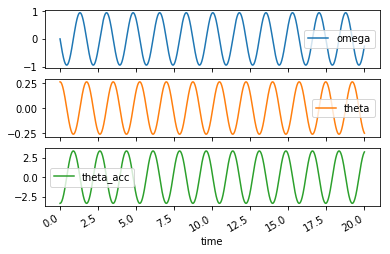

In [30]:
nl_traj.plot(subplots=True);

# Linearizing the Equations of Motion

Assume $\theta$ is small, therefore:

- $\sin\theta = \theta$
- $\cos(\theta) = 1$
- $\theta \cdot \theta = 0$
- $\dot{\theta} \cdot \dot{\theta} = 0$
- $\sin^2\theta = \theta^2 = 0$

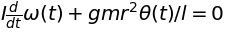

In [31]:
zero = zero.subs({theta.diff(): omega})
zero_lin = zero.subs({sm.sin(theta): theta,
                      sm.cos(theta): 1,
                      sm.sin(theta / 2): theta / 2,
                      sm.cos(theta / 2): 1,
                      theta**2: 0,
                      omega**2: 0,
                     }).subs(theta**2, 0)  # have to get this last one because order of subs matters
sm.Eq(zero_lin, 0)

# Simulating the linear equations of motion

In [32]:
from resonance.linear_systems import SingleDoFLinearSystem

In [33]:
sys = SingleDoFLinearSystem()

In [34]:
sys.constants['m'] = 1  # kg
sys.constants['r'] = 0.3  # m
sys.constants['l'] = 0.7  # m
sys.constants['g'] = 9.81  # m/s**2
sys.constants['I'] = 0.3**2  # kg m**2

In [35]:
sys.coordinates['theta'] = np.deg2rad(15)  # rad
sys.speeds['omega'] = 0.0  # rad/s

In [36]:
def coeffs(m, r, l, g, I):
    k = g * m * r**2 / l
    return I, 0, k

In [37]:
sys.canonical_coeffs_func = coeffs

In [38]:
traj = sys.free_response(5.0)

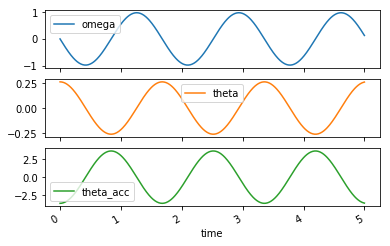

In [39]:
traj.plot(subplots=True);

# Compare the nonlinear and linear motion

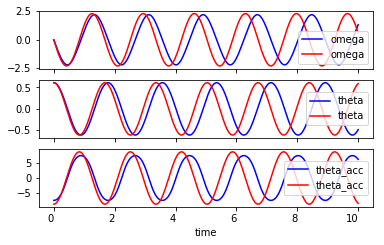

In [40]:
initial_angle = 35  # degrees

nl_sys.coordinates['theta'] = np.deg2rad(initial_angle)
sys.coordinates['theta'] = np.deg2rad(initial_angle)

nl_traj = nl_sys.free_response(10)
traj = sys.free_response(10)

axes = nl_traj.plot(subplots=True, color='blue')
traj.plot(subplots=True, ax=axes, color='red');